# Crypto-currency Price Prediction using LSTM (Long-Short Term Memory) Model

Notebook is divided into Sections :<br>
1. Data Import<br>
2. Understanding the distribution of the data<br>
3. Data Transformation<br>
4. Model Building<br>
5. Model Training<br>
6. Cross-Validating the model<br>

In [48]:
# Importing the required libraries
import pandas  as pd 
import numpy as np
import matplotlib.pyplot as plt 
import pandas_datareader as web
import datetime as dt 
import yfinance as yf
import sktime
import pandas_datareader.data as pdr
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from tensorflow.keras.layers import Dense, Dropout, LSTM, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from pycaret.regression import *

## Data Import

Choose the cryptocurrency we want to predict, and the period of time whose data we want to collect.

In [19]:
crypto_currency = 'BNB'
against_currency ='USD'
start = dt.datetime(2021,1,1)
end = dt.datetime.now()-dt.timedelta(days=50)

Extracting the above chosen data using Yahoo-Finance API

In [20]:
yf.pdr_override()
data = pdr.get_data_yahoo("BNB-USD", start, end)
# Importing the extracted data in PyCaret
df = setup(data,target = "Close",ignore_features=["Volume","Adj Close"], use_gpu=True,imputation_type='iterative', feature_ratio=True, feature_interaction=True, normalize=True, transform_target=True)           

,Description,Value
0,session_id,413
1,Target,Close
2,Original Data,"(139, 6)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(97, 4)"


## Understaning the distribution of the data

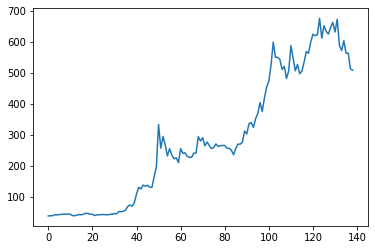

In [13]:
# Distribution of our target variable -> Close
from scipy.special import boxcox1p
plt.plot(np.array(final_data["Close"]))

### Checking if our series is affected by past values

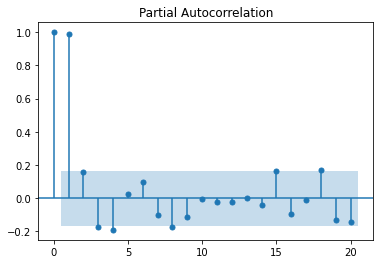

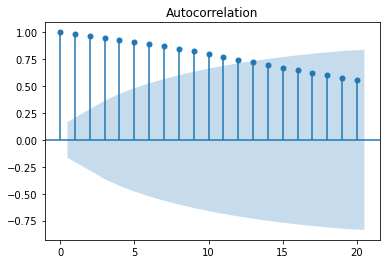

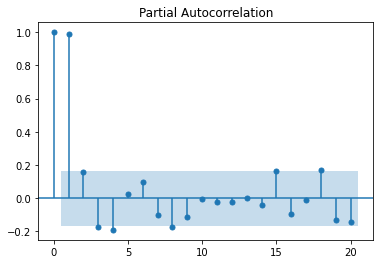

In [25]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Close'], lags=20)
plot_pacf(data['Close'], lags=20)

From the above plots, lags are highly correlated to the value at hand. This will be useful while preparing the data for the model, and we will pass tha value, based on the above Observation.

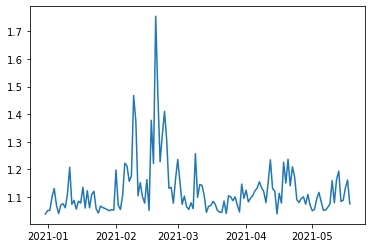

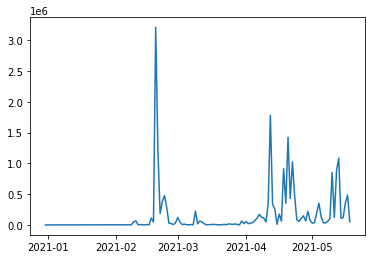

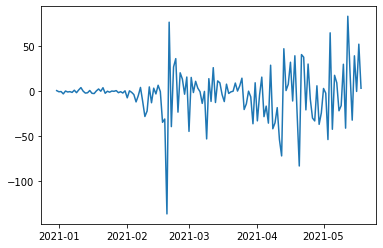

In [43]:
plt.figure() 
plt.plot(data["High"]/data["Low"])
plt.figure()
plt.plot((np.power(data["High"]-data["Low"],3)))
plt.figure()
plt.plot(data["Open"]-data["Close"])

## Data Cleaning and Transformation

In [27]:
print(data.isnull().sum())     # checking for missing values

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Section for trying sktime library, if it can help us transform the Time-Series

In [44]:
# from sktime.utils.plotting import plot_series
# from sktime.transformations.panel.rocket import Rocket
# y = data["Close"]
# x = data[data.columns]
# x.drop(["Close","Volume"],axis=1,inplace=True)
# plot_series(data["Close"])
# rocket = Rocket()
# rocket.fit(np.array(x))
# x_t = rocket.transform(np.array(x))

### Defining methods for transforming time-series data

In [29]:
def difference(data, interval=1):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]
def invert_difference(orig_data, diff_data, interval=1):
	return [diff_data[i-interval] + orig_data[i-interval] for i in range(interval, len(orig_data))]

from scipy.stats import boxcox
# fd =(boxcox1p(final_data["Close"]))#*np.log(boxcox1p(final_data["Close"],-1))
# plt.plot(fd)

The idea here is to store the data at each step, without losing/replacing it. <br>Thus, creating new variables wherever required to store the new/transformed data in the new variable.

Adding two new Attributes to the dataset, based on the plots and Observations of the previous section.<br>Some Transformations are commented, cause they were not a suitable fit, but might be useful later.

In [45]:
final_data = pd.DataFrame()
final_data["Close_Open"] = data['Close']-data['Open']
final_data["High_Low"] = data['High']-data['Low']
final_data['t1'] = (np.power(data["High"]-data["Low"],3))
final_data['Close'] = data['Close']

final_data.head()
# scaler = PowerTransformer(method="yeo-johnson", standardize=True)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_data.values)
# logged_data = np.log10(data['Close'])
# scaled_data, lambda_data = (boxcox(data['Close']))#difference(logged_data).to_numpy()
# new = difference((data['Close'],1)
# scaled_data = pd.Series(scaled_data)

### Preparing the data

In [47]:
# Preparing the Data
prediction_days = 7
future_days=0
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_days):
    x_train.append(scaled_data[x-prediction_days:x])
    y_train.append(scaled_data[x+future_days,scaled_data.shape[1]-1])
x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))
# range(prediction_days, len(scaled_data))x_train
x_train.shape

(132, 7, 4)

## Model Building

In [36]:
# custom metric for our model, only to monitor our model while training
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [37]:
#creating neural netowrk
# from attention_decoder import AttentionDecoder

model = Sequential()                # could make units 50, for better prediction
model.add(LayerNormalization())
model.add(LSTM(units=500,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2]),activation="relu",unroll=True))
model.add(Dropout(0.05))
model.add(LSTM(units=500, activation="relu",unroll=True, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50,activation="relu"))
# model.add(Dense(units=500, activation="relu"))
# model.add(Dropout(0.2))

model.add(LSTM(units=1,activation="relu"))
model.compile(optimizer='adam', loss='mean_squared_error',metrics=[rmse])
model.fit(x_train,y_train, epochs=80, batch_size=100)

Epoch 1/80
2/2 [==============================] - 8s 42ms/step - loss: 0.2428 - rmse: 0.3838
Epoch 2/80
2/2 [==============================] - 0s 35ms/step - loss: 0.0992 - rmse: 0.2430
Epoch 3/80
2/2 [==============================] - 0s 34ms/step - loss: 0.0433 - rmse: 0.1851
Epoch 4/80
2/2 [==============================] - 0s 33ms/step - loss: 0.0145 - rmse: 0.0926
Epoch 5/80
2/2 [==============================] - 0s 42ms/step - loss: 0.0220 - rmse: 0.1058
Epoch 6/80
2/2 [==============================] - 0s 34ms/step - loss: 0.0172 - rmse: 0.0918
Epoch 7/80
2/2 [==============================] - 0s 41ms/step - loss: 0.0180 - rmse: 0.0938
Epoch 8/80
2/2 [==============================] - 0s 33ms/step - loss: 0.0136 - rmse: 0.0822
Epoch 9/80
2/2 [==============================] - 0s 40ms/step - loss: 0.0137 - rmse: 0.0816
Epoch 10/80
2/2 [==============================] - 0s 35ms/step - loss: 0.0155 - rmse: 0.0889
Epoch 11/80
2/2 [==============================] - 0s 35ms/step - los

[*********************100%***********************]  1 of 1 completed


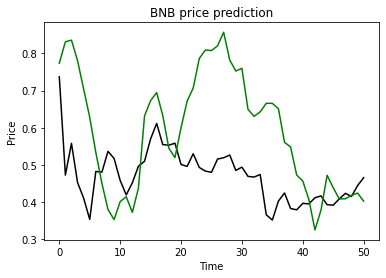

In [38]:
test_start = dt.datetime.now()-dt.timedelta(days=50)
test_end = dt.datetime.now()

test_data = pdr.get_data_yahoo("BNB-USD", test_start, test_end)

final_test = pd.DataFrame()
final_test['Close_Open'] = test_data['Close'] - test_data['Open']
final_test['High_Low'] = test_data['High'] - test_data['Low']
final_test['t1'] = np.power(test_data["High"]-test_data["Low"],3)
final_test['Close'] = test_data['Close']

total_dataset = pd.concat((final_data,final_test),axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data)-prediction_days:]
# model_inputs=difference(np.log10((model_inputs))).to_numpy()
# model_inputs = model_inputs
model_inputs = scaler.transform(model_inputs)
actual_prices = (model_inputs[prediction_days:,scaled_data.shape[1]-1])#difference(np.log10((test_data['Close']))).to_numpy()



x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x])
x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

prediction_prices = model.predict(x_test)
# prediction_prices = scaler.inverse_transform(prediction_prices)
# prediction_prices = scaler.inverse_transform(prediction_prices) 
plt.plot(actual_prices,color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.legend(loc='lower left')
plt.show()

5/5 [==============================] - 0s 9ms/step - loss: 0.0013 - rmse: 0.0267


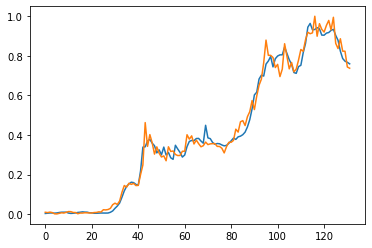

In [39]:
# # Predict Next Day
# real_data = [model_inputs[len(model_inputs) +1 - prediction_days: len(model_inputs) + 1,0]]
# real_data = np.reshape(real_data,-1)
# real_data = np.reshape(real_data, (real_data.shape))
# prediction = model.predict(real_data)
# prediction = scaler.inverse_transform(prediction)
# print()
# (prediction_prices)
# plottiong training dataset  
model.evaluate(x_test,actual_prices)
model.evaluate(x_train,y_train)
plt.plot(model.predict(x_train))
plt.plot(y_train)

In [40]:
re = data['Close']).reshape(-1,1)
data2 = scaler.fit_transform(re)
# data2[3:]
plt.plot(difference(np.log10((data2))).to_numpy(),color='black', label='Actual Prices')

SyntaxError: unmatched ')' (<ipython-input-40-9cbb75c363d4>, line 1)

In [ ]:
pd.Series(np.array(boxcox(data['Close'])))

In [ ]:
# plt.plot(data['Open'])
# plt.plot(data['Close'])
plt.plot(data['High'] - data['Low'])
plt.plot(data['Close'] - data['Open'])
# plt.plot(data['Close'] - data['High'])
# plt.plot(data['Close'] - data['Low'])
# plt.plot(data['Low'])

## Bottom Line Notes
for 1000 epochs, model is overfitting, 500 seems fine to me. Might decrease the epochs from 500
Optimizer and loss are alright to i guess.
activation function is next (marked in to-do in github projects)

In [ ]:
# #creating neural netowrk  Good Model
# model = Sequential()                # could make units 50, for better prediction
# model.add(LSTM(units=500, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]), activation="relu" ))
# # model.add(Dropout(0.2))
# model.add(LSTM(units=500, activation="relu"))
# # model.add(Dropout(0.2))
# # model.add(LSTM(units=50,activation="relu"))
# # model.add(Dense(units=100, activation="relu"))
# # model.add(Dropout(0.2))

# model.add(Dense(units=1,activation="relu"))
# model.compile(optimizer='adam', loss='mean_squared_error',metrics=[rmse])
# model.fit(x_train,y_train, epochs=100, batch_size=10)